### ITSM Ticket automation using RNN


1. NLP using LSTM to the Description of the problem
2. Run RNN for the attributes

In [49]:
import keras 
import numpy as np
from keras.preprocessing.text import Tokenizer
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, Flatten
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [50]:
data = pd.read_csv('/Users/jairomelo/Desktop/ML/YORK/ML1030/Capstone Project/incident 05-09-19.csv', encoding = "cp1252")

### Actions:
1. Balance the data sample.
2. Description has null values; we will use short description in case of missing description, and filter any record where no description nor short description is provided
3. Removing any occurence where 

In [51]:
# replacing na values in description with the Short Description 
data["Description"].fillna(data["Short_Description"], inplace = True) 
data = data.dropna(subset = ['Resolved_by_group'])


In [52]:
#Cleaning Description using short description for observations recorded by Netcool Alerting tool
data['Description'] = data.apply(
    lambda row: row.Short_Description if 'Netcool Fields:' in row.Description else row.Description ,  axis = 1)


In [53]:
data.head()

,Number,Description,Short_Description,Caller,Priority,Category,Sub_Category,Urgency,Impact,Configuration_item,...,Assignment_group,State.1,Resolution_category,Site,Resolved_by_group,Resolved_by,KCS_solution,CI_regions,Created,Resolved
0,INC000017612819,SIMS blank page when open with IE\r\n??IE ??S...,SIMS blank page,YUTONG ZHOU (152062324),Priority 4,Software,Website,Low,Limited,SIMS LATAM,...,GLOBAL SERVICE DESK,Closed Complete,Change Implementation,NaN,GLOBAL SERVICE DESK,JING HUANG (645010504),KB000010025934,LATAM,2017-11-12 21:03,2017-11-12 21:03
1,INC000020585404,"For dim_slt_id=203, dim_task_id=1658 exited wi...",TASK_STATUS - SLT ID 203,AGGRIFY SLT AUTOMATION (702303384),Priority 4,Application,Job Failure,Low,Limited,MENTOR BI SALES ANALYTICS,...,DATA AND ANALYTICS RR LTI,Closed Complete,Job Failure,NA US NJ RARITAN,DATA AND ANALYTICS RR LTI,DILIP KHANDAI (643026421),KB000010080602,NaN,2019-08-04 3:30,2019-08-06 6:39
2,INC000020692831,"For DIM_SLT_ID=203, following task(s) violated...",TASK_END_DELAY violated for DIM_SLT_ID 203,AGGRIFY SLT AUTOMATION (702303384),Priority 4,Application,Poor performance,Low,Limited,MENTOR BI SALES ANALYTICS,...,DATA AND ANALYTICS RR LTI,Draft,Job Failure,NA US NJ RARITAN,DATA AND ANALYTICS RR LTI,DILIP KHANDAI (643026421),KB000010081617,NaN,2019-08-24 2:15,2019-08-28 4:55
3,INC000017000450,??????,Software - J&J business applications: Unavaila...,ZHIYU ZHANG (85434123),Priority 4,Software,Website,Low,Localized,JJMC IPOWER -- PROF ED HCP MASTER DATABASE,...,AS MEDICAL APP CHINA L2,Closed Complete,User Access / Permission,ASPAC CN SHANGHAI,AS MEDICAL APP CHINA L2,WEI WANG (702020246),NaN,ASPAC,2017-06-27 3:26,2017-06-29 2:04
4,INC000017291067,> DS huddle Login issue,> DS huddle Login issue,SEAN FOLEY (702113126),Priority 4,Software,Desktop Software,Low,Localized,DS MOBILE,...,GLOBAL SERVICE DESK,Closed Complete,User Access / Permission,NA US NJ RARITAN,GLOBAL SERVICE DESK,ABEGAIL COMON (645001723),KB000010027981,NaN,2017-08-31 10:34,2017-08-31 14:36


In [55]:
data = data.groupby('Resolved_by_group').filter(lambda x : len(x)>500)

In [56]:
data.Resolved_by_group.value_counts()

DATA AND ANALYTICS RR LTI          8475
CBT RR COG                         7659
DATA AND ANALYTICS RR TCS          7135
GLOBAL SERVICE DESK                4994
DATA AND ANALYTICS RR COG          1749
ASPAC CONSUMER DNA L2              1615
C3I LEVEL I                        1379
GLOBAL ANALYTICS CONSUMER          1341
GLOBAL ANALYTICS PHARMA            1161
DIG ECOM SOC COL RR COG            1125
ITAS ETCS FINANCIAL SERVICES L2     933
GFS-FP&A COE TM1                    907
DIG ECOM SOC COL RR TCS             623
BI-COGNOS                           589
GFS-FP&A COE FDW                    582
AS_MDD_EMEA_COMMANLYCS_L2           554
AS DATAWAREHOUSE L2                 542
Name: Resolved_by_group, dtype: int64

In [106]:
data.shape

(41363, 35)

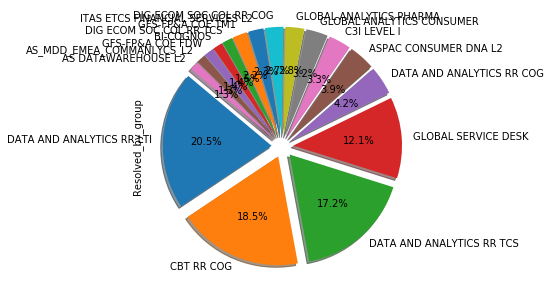

In [58]:
chart=data.Resolved_by_group.value_counts()
explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1)
plot = chart.plot.pie(y='Resolved_by_group', figsize=(5, 5), explode=explode, subplots=True, autopct='%1.1f%%', shadow=True, startangle=140)


from sklearn.utils import resample

df_1 = data[data.Resolved_by_group=='DATA AND ANALYTICS RR LTI']
df_2 = data[data.Resolved_by_group=='CBT RR COG']
df_3 = data[data.Resolved_by_group=='DATA AND ANALYTICS RR TCS']
df_4 = data[data.Resolved_by_group=='GLOBAL SERVICE DESK']
df_5 = data[data.Resolved_by_group=='DATA AND ANALYTICS RR COG']
df_6 = data[data.Resolved_by_group=='ASPAC CONSUMER DNA L2']
df_7 = data[data.Resolved_by_group=='C3I LEVEL I']
df_8 = data[data.Resolved_by_group=='GLOBAL ANALYTICS CONSUMER']
df_9 = data[data.Resolved_by_group=='GLOBAL ANALYTICS PHARMA']
df_10 = data[data.Resolved_by_group=='DIG ECOM SOC COL RR COG']


df_1_upsampled = resample(df_1, 
                                 replace=True,     # sample with replacement
                                 n_samples=1125,    # to match majority class
                                 random_state=123) # reproducible results

df_2_upsampled = resample(df_2, 
                                 replace=True,     # sample with replacement
                                 n_samples=1125,    # to match majority class
                                 random_state=123) # reproducible results

df_3_upsampled = resample(df_3, 
                                 replace=True,     # sample with replacement
                                 n_samples=1125,    # to match majority class
                                 random_state=123) # reproducible results

df_4_upsampled = resample(df_4, 
                                 replace=True,     # sample with replacement
                                 n_samples=1125,    # to match majority class
                                 random_state=123) # reproducible results

df_5_upsampled = resample(df_5, 
                                 replace=True,     # sample with replacement
                                 n_samples=1125,    # to match majority class
                                 random_state=123) # reproducible results

df_6_upsampled = resample(df_6, 
                                 replace=True,     # sample with replacement
                                 n_samples=1125,    # to match majority class
                                 random_state=123) # reproducible results

df_7_upsampled = resample(df_7, 
                                 replace=True,     # sample with replacement
                                 n_samples=1125,    # to match majority class
                                 random_state=123) # reproducible results

df_8_upsampled = resample(df_8, 
                                 replace=True,     # sample with replacement
                                 n_samples=1125,    # to match majority class
                                 random_state=123) # reproducible results

df_9_upsampled = resample(df_9, 
                                 replace=True,     # sample with replacement
                                 n_samples=1125,    # to match majority class
                                 random_state=123) # reproducible results

df_10_upsampled = resample(df_10, 
                                 replace=True,     # sample with replacement
                                 n_samples=1125,    # to match majority class
                                 random_state=123) # reproducible results

# Combine majority class with upsampled minority class
data = pd.concat([df_1_upsampled, df_2_upsampled, df_3_upsampled, df_4_upsampled, df_5_upsampled, df_6_upsampled, df_7_upsampled, df_8_upsampled, df_9_upsampled, df_10_upsampled])

In [10]:
data.Resolved_by_group.value_counts()

GLOBAL SERVICE DESK          1125
DATA AND ANALYTICS RR TCS    1125
DATA AND ANALYTICS RR COG    1125
CBT RR COG                   1125
GLOBAL ANALYTICS PHARMA      1125
ASPAC CONSUMER DNA L2        1125
DATA AND ANALYTICS RR LTI    1125
GLOBAL ANALYTICS CONSUMER    1125
C3I LEVEL I                  1125
DIG ECOM SOC COL RR COG      1125
Name: Resolved_by_group, dtype: int64

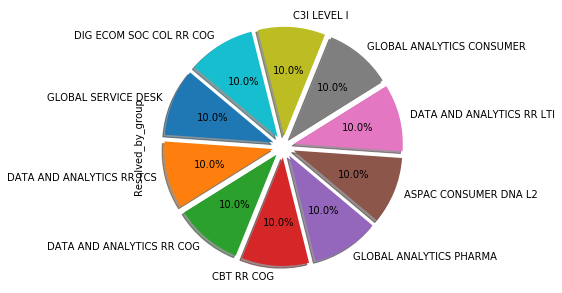

In [11]:
chart=data.Resolved_by_group.value_counts()
explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1)
plot = chart.plot.pie(y='Resolved_by_group', figsize=(5, 5), explode=explode, subplots=True, autopct='%1.1f%%', shadow=True, startangle=140)


In [59]:
data['target_grp'] = data.Resolved_by_group.astype('category').cat.codes


In [60]:
labels_grp = data.Resolved_by_group.astype('category').cat.categories


In [61]:
df = pd.DataFrame(labels_grp) 
df.to_csv ('/Users/jairomelo/Desktop/ML/YORK/ML1030/Capstone Project/labels_grp.csv')


In [62]:
data.head()

,Number,Description,Short_Description,Caller,Priority,Category,Sub_Category,Urgency,Impact,Configuration_item,...,State.1,Resolution_category,Site,Resolved_by_group,Resolved_by,KCS_solution,CI_regions,Created,Resolved,target_grp
0,INC000017612819,SIMS blank page when open with IE\r\n??IE ??S...,SIMS blank page,YUTONG ZHOU (152062324),Priority 4,Software,Website,Low,Limited,SIMS LATAM,...,Closed Complete,Change Implementation,NaN,GLOBAL SERVICE DESK,JING HUANG (645010504),KB000010025934,LATAM,2017-11-12 21:03,2017-11-12 21:03,15
1,INC000020585404,"For dim_slt_id=203, dim_task_id=1658 exited wi...",TASK_STATUS - SLT ID 203,AGGRIFY SLT AUTOMATION (702303384),Priority 4,Application,Job Failure,Low,Limited,MENTOR BI SALES ANALYTICS,...,Closed Complete,Job Failure,NA US NJ RARITAN,DATA AND ANALYTICS RR LTI,DILIP KHANDAI (643026421),KB000010080602,NaN,2019-08-04 3:30,2019-08-06 6:39,7
2,INC000020692831,"For DIM_SLT_ID=203, following task(s) violated...",TASK_END_DELAY violated for DIM_SLT_ID 203,AGGRIFY SLT AUTOMATION (702303384),Priority 4,Application,Poor performance,Low,Limited,MENTOR BI SALES ANALYTICS,...,Draft,Job Failure,NA US NJ RARITAN,DATA AND ANALYTICS RR LTI,DILIP KHANDAI (643026421),KB000010081617,NaN,2019-08-24 2:15,2019-08-28 4:55,7
4,INC000017291067,> DS huddle Login issue,> DS huddle Login issue,SEAN FOLEY (702113126),Priority 4,Software,Desktop Software,Low,Localized,DS MOBILE,...,Closed Complete,User Access / Permission,NA US NJ RARITAN,GLOBAL SERVICE DESK,ABEGAIL COMON (645001723),KB000010027981,NaN,2017-08-31 10:34,2017-08-31 14:36,15
5,INC000017753898,This is just a question.\r\nDo Secondary Admin...,"Cloud computing (Virtual PC, VPCx): Virtual PC",YUKO YOSHIZUMI (643002449),Priority 4,Help/ Assistance,Information,Low,Limited,ACUVUE WEBSITE,...,Closed Complete,User Access / Permission,ASPAC JP TOKYO,GLOBAL SERVICE DESK,LIELANI SY (645001390),NaN,"ASPAC, NA",2017-12-12 3:35,2017-12-12 7:16,15


In [63]:
data['num_words'] = data['Description'].apply(lambda x : len(x.split()))

In [64]:
bins=[0,50,75, np.inf]
data['bins']=pd.cut(data.num_words, bins=[0,10,30,60,130, np.inf], labels=['0-10', '10-30', '30-60','60-130' ,'>130'])


In [65]:
word_distribution = data.groupby('bins').size().reset_index().rename(columns={0:'counts'})

In [66]:
word_distribution.head()

,bins,counts
0,0-10,10340
1,10-30,19247
2,30-60,7454
3,60-130,3670
4,>130,652


Text(0.5, 1.0, 'Word distribution per bin')

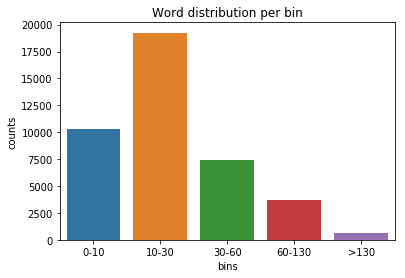

In [67]:
sns.barplot(x='bins', y='counts', data=word_distribution).set_title("Word distribution per bin")

In [68]:
data.head()

,Number,Description,Short_Description,Caller,Priority,Category,Sub_Category,Urgency,Impact,Configuration_item,...,Site,Resolved_by_group,Resolved_by,KCS_solution,CI_regions,Created,Resolved,target_grp,num_words,bins
0,INC000017612819,SIMS blank page when open with IE\r\n??IE ??S...,SIMS blank page,YUTONG ZHOU (152062324),Priority 4,Software,Website,Low,Limited,SIMS LATAM,...,NaN,GLOBAL SERVICE DESK,JING HUANG (645010504),KB000010025934,LATAM,2017-11-12 21:03,2017-11-12 21:03,15,10,0-10
1,INC000020585404,"For dim_slt_id=203, dim_task_id=1658 exited wi...",TASK_STATUS - SLT ID 203,AGGRIFY SLT AUTOMATION (702303384),Priority 4,Application,Job Failure,Low,Limited,MENTOR BI SALES ANALYTICS,...,NA US NJ RARITAN,DATA AND ANALYTICS RR LTI,DILIP KHANDAI (643026421),KB000010080602,NaN,2019-08-04 3:30,2019-08-06 6:39,7,8,0-10
2,INC000020692831,"For DIM_SLT_ID=203, following task(s) violated...",TASK_END_DELAY violated for DIM_SLT_ID 203,AGGRIFY SLT AUTOMATION (702303384),Priority 4,Application,Poor performance,Low,Limited,MENTOR BI SALES ANALYTICS,...,NA US NJ RARITAN,DATA AND ANALYTICS RR LTI,DILIP KHANDAI (643026421),KB000010081617,NaN,2019-08-24 2:15,2019-08-28 4:55,7,20,10-30
4,INC000017291067,> DS huddle Login issue,> DS huddle Login issue,SEAN FOLEY (702113126),Priority 4,Software,Desktop Software,Low,Localized,DS MOBILE,...,NA US NJ RARITAN,GLOBAL SERVICE DESK,ABEGAIL COMON (645001723),KB000010027981,NaN,2017-08-31 10:34,2017-08-31 14:36,15,5,0-10
5,INC000017753898,This is just a question.\r\nDo Secondary Admin...,"Cloud computing (Virtual PC, VPCx): Virtual PC",YUKO YOSHIZUMI (643002449),Priority 4,Help/ Assistance,Information,Low,Limited,ACUVUE WEBSITE,...,ASPAC JP TOKYO,GLOBAL SERVICE DESK,LIELANI SY (645001390),NaN,"ASPAC, NA",2017-12-12 3:35,2017-12-12 7:16,15,31,30-60


In [69]:
num_class_grp = len(np.unique(data.Resolved_by_group.values))
y_grp = data['target_grp'].values


## Topic Modelling

In [70]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import numpy as np
import pandas as pd
import re
import warnings
from sklearn.metrics import confusion_matrix
#Visualisation
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from IPython.display import display
#from mpl_toolkits.basemap import Basemap
from wordcloud import WordCloud, STOPWORDS

#nltk
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize

In [71]:
data['Description'] = data['Description'].astype(str)

In [72]:
type(data['Description'])

pandas.core.series.Series

In [73]:
data_description = data.Description.values

In [74]:
type(data_description)

numpy.ndarray

In [75]:
#cv = # Initialize a CountVectorizer object: count_vectorizer
count_vec = CountVectorizer(stop_words="english", analyzer='word', 
                            ngram_range=(1, 1), max_df=1, min_df=1, max_features=None)

# convert text data into term-frequency matrix
data_description = count_vec.fit_transform(data_description)




tfidf_transformer = TfidfTransformer()

# convert term-frequency matrix into tf-idf
tfidf_matrix = tfidf_transformer.fit_transform(data_description)

# create dictionary to find a tfidf word each word
word2tfidf = dict(zip(count_vec.get_feature_names(), tfidf_transformer.idf_))

for word, score in word2tfidf.items():
    print(word, score)

000000 10.937019035744921
000000000000080001 10.937019035744921
000000000000080002 10.937019035744921
000000000000080003 10.937019035744921
000000000000080004 10.937019035744921
000000000000080005 10.937019035744921
000000000000080006 10.937019035744921
000000000000080007 10.937019035744921
000000000000080008 10.937019035744921
000000000000080009 10.937019035744921
000000000000080010 10.937019035744921
000000000000080011 10.937019035744921
000000000000080015 10.937019035744921
000000000000080018 10.937019035744921
000000000000080019 10.937019035744921
000000000000080020 10.937019035744921
000000000000080021 10.937019035744921
000000000000080022 10.937019035744921
000000000000080023 10.937019035744921
000000000000080024 10.937019035744921
000000000000080025 10.937019035744921
000000000000080026 10.937019035744921
000000000000080027 10.937019035744921
000000000000080028 10.937019035744921
000000000000080029 10.937019035744921
000000000000080030 10.937019035744921
000000000000080033 10.93

11975 10.937019035744921
11979 10.937019035744921
11980 10.937019035744921
11983 10.937019035744921
11995 10.937019035744921
11997 10.937019035744921
11998 10.937019035744921
119_cube 10.937019035744921
119_orchestration_product_summary_report 10.937019035744921
119k 10.937019035744921
11e 10.937019035744921
11e1 10.937019035744921
11h 10.937019035744921
11k 10.937019035744921
11p9l 10.937019035744921
11silin 10.937019035744921
1200 10.937019035744921
1200000234 10.937019035744921
12001 10.937019035744921
12001027001 10.937019035744921
12018 10.937019035744921
12022013001 10.937019035744921
12023099001 10.937019035744921
12027 10.937019035744921
12029 10.937019035744921
12030 10.937019035744921
12032 10.937019035744921
1205 10.937019035744921
12050 10.937019035744921
12051 10.937019035744921
12058 10.937019035744921
12060 10.937019035744921
12062 10.937019035744921
12066 10.937019035744921
12067 10.937019035744921
12069 10.937019035744921
12072 10.937019035744921
12074 10.9370190357449

211924 10.937019035744921
21193 10.937019035744921
21194 10.937019035744921
21195 10.937019035744921
21196 10.937019035744921
212001 10.937019035744921
212005 10.937019035744921
21201 10.937019035744921
212032 10.937019035744921
212035 10.937019035744921
212044 10.937019035744921
212051 10.937019035744921
2121 10.937019035744921
212264 10.937019035744921
2124 10.937019035744921
21250 10.937019035744921
212597 10.937019035744921
21279 10.937019035744921
2128 10.937019035744921
2132 10.937019035744921
213224 10.937019035744921
2133 10.937019035744921
2134 10.937019035744921
213417 10.937019035744921
2135 10.937019035744921
213584 10.937019035744921
21377 10.937019035744921
21378 10.937019035744921
21379 10.937019035744921
213822 10.937019035744921
213934 10.937019035744921
213960003 10.937019035744921
21398 10.937019035744921
213995001 10.937019035744921
214070 10.937019035744921
21409 10.937019035744921
214095237066 10.937019035744921
2141 10.937019035744921
214120 10.937019035744921
21

402869 10.937019035744921
4030506 10.937019035744921
4032 10.937019035744921
4040j 10.937019035744921
404254 10.937019035744921
404266 10.937019035744921
404293 10.937019035744921
404294 10.937019035744921
4043 10.937019035744921
404420 10.937019035744921
4048 10.937019035744921
40500023 10.937019035744921
40500164 10.937019035744921
405696 10.937019035744921
40640 10.937019035744921
407 10.937019035744921
4070 10.937019035744921
40709 10.937019035744921
407a 10.937019035744921
407c 10.937019035744921
408364082f4c4a6a82a5ba0c9c9bb5ee 10.937019035744921
408c 10.937019035744921
4090 10.937019035744921
4090453 10.937019035744921
409355 10.937019035744921
4093996 10.937019035744921
4095 10.937019035744921
4096 10.937019035744921
4097 10.937019035744921
40c5 10.937019035744921
40cherrissa 10.937019035744921
40fa 10.937019035744921
40its 10.937019035744921
40minutes 10.937019035744921
40robert 10.937019035744921
40s 10.937019035744921
40z 10.937019035744921
41000546 10.937019035744921
410005

4710401 10.937019035744921
4710549 10.937019035744921
4710583 10.937019035744921
4711029 10.937019035744921
4711040 10.937019035744921
4711060 10.937019035744921
4711134 10.937019035744921
4711229 10.937019035744921
4711342 10.937019035744921
4711375 10.937019035744921
4711671 10.937019035744921
4711720 10.937019035744921
4711828 10.937019035744921
4711981 10.937019035744921
4712025 10.937019035744921
4712455 10.937019035744921
4712498 10.937019035744921
4712508 10.937019035744921
4712564 10.937019035744921
4712594 10.937019035744921
4712601 10.937019035744921
4713423 10.937019035744921
4713748 10.937019035744921
4713945 10.937019035744921
4714073 10.937019035744921
4714143 10.937019035744921
4714171 10.937019035744921
4714549 10.937019035744921
4714550 10.937019035744921
4714572 10.937019035744921
4714680 10.937019035744921
4714815 10.937019035744921
4714925 10.937019035744921
4714937 10.937019035744921
4715019 10.937019035744921
4715463 10.937019035744921
4715464 10.937019035744921
4

6100 10.937019035744921
6107 10.937019035744921
6107kb 10.937019035744921
6108 10.937019035744921
6109 10.937019035744921
611 10.937019035744921
6110 10.937019035744921
6110003 10.937019035744921
6110005 10.937019035744921
6110006 10.937019035744921
6110007 10.937019035744921
6110008 10.937019035744921
6110009 10.937019035744921
61110 10.937019035744921
6116 10.937019035744921
611632025 10.937019035744921
612 10.937019035744921
6120001 10.937019035744921
6120002 10.937019035744921
6120003 10.937019035744921
6120004 10.937019035744921
6120005 10.937019035744921
6120006 10.937019035744921
6120007 10.937019035744921
6120008 10.937019035744921
6120009 10.937019035744921
6120010 10.937019035744921
6123 10.937019035744921
61241 10.937019035744921
61286 10.937019035744921
6130001 10.937019035744921
6130002 10.937019035744921
6130003 10.937019035744921
6130004 10.937019035744921
6130005 10.937019035744921
6130006 10.937019035744921
6130007 10.937019035744921
6130008 10.937019035744921
6130009 

a601 10.937019035744921
a61b 10.937019035744921
a65b 10.937019035744921
a6c0 10.937019035744921
a6ed 10.937019035744921
a70ca8a5 10.937019035744921
a77ec672 10.937019035744921
a7abce1e 10.937019035744921
a8 10.937019035744921
a88 10.937019035744921
a8fd 10.937019035744921
a911 10.937019035744921
a921 10.937019035744921
a93b088bd141 10.937019035744921
a96b 10.937019035744921
a97adb57 10.937019035744921
a9n 10.937019035744921
aa015fea 10.937019035744921
aaa 10.937019035744921
aaa4 10.937019035744921
aaa_global 10.937019035744921
aaabzlotz7e 10.937019035744921
aaadeployment 10.937019035744921
aadca0638874 10.937019035744921
aadsts90094 10.937019035744921
aaeh 10.937019035744921
aakamine 10.937019035744921
aale 10.937019035744921
aallardd 10.937019035744921
aalst 10.937019035744921
aam 10.937019035744921
aanmelding 10.937019035744921
aaoz 10.937019035744921
aap 10.937019035744921
aardesjo 10.937019035744921
aaron 10.937019035744921
aasa 10.937019035744921
aashish 10.937019035744921
aashokr

brazil_onemd_ans_bi_test 10.937019035744921
brazil_sales_operation_optymyze_product_by_bucket 10.937019035744921
brazão 10.937019035744921
breaches 10.937019035744921
breaching 10.937019035744921
breadcrumb 10.937019035744921
bready 10.937019035744921
breakage 10.937019035744921
breakconnection 10.937019035744921
breath 10.937019035744921
breathable 10.937019035744921
bredisplayed 10.937019035744921
bree 10.937019035744921
breedon 10.937019035744921
brennan 10.937019035744921
brett 10.937019035744921
breve 10.937019035744921
brick 10.937019035744921
brickpool 10.937019035744921
bridget 10.937019035744921
bridgewater 10.937019035744921
bridging 10.937019035744921
brien 10.937019035744921
bright 10.937019035744921
brightcove_video_job 10.937019035744921
brigitte 10.937019035744921
brilho 10.937019035744921
brillau 10.937019035744921
brittney 10.937019035744921
brm 10.937019035744921
broadcasts 10.937019035744921
broadway 10.937019035744921
brochu 10.937019035744921
broked 10.937019035744

databackbone 10.937019035744921
databse 10.937019035744921
datacollection 10.937019035744921
dataconnectionextensions 10.937019035744921
datafile 10.937019035744921
dataflow 10.937019035744921
dataframe 10.937019035744921
dataintegrityviolationexception 10.937019035744921
datamgmt 10.937019035744921
datapipe 10.937019035744921
dataready 10.937019035744921
dataservices 10.937019035744921
datasteward 10.937019035744921
datastream 10.937019035744921
dataview 10.937019035744921
datawaehouse 10.937019035744921
date_field 10.937019035744921
date_of_appointment 10.937019035744921
date_received 10.937019035744921
datei 10.937019035744921
datenschutzfehler 10.937019035744921
datenverlust 10.937019035744921
datenübertragung 10.937019035744921
dating 10.937019035744921
dats 10.937019035744921
datta 10.937019035744921
datum 10.937019035744921
daughter 10.937019035744921
davy 10.937019035744921
dawkins 10.937019035744921
dawson 10.937019035744921
daylight 10.937019035744921
daytime 10.9370190357449

fdwrefresh 10.937019035744921
fe020_v_a001 10.937019035744921
fe022_v_a001 10.937019035744921
fe051_v_a001 10.937019035744921
fe084_v_a001 10.937019035744921
fe846988fbfd4569be4332d9f01e6163 10.937019035744921
feaf 10.937019035744921
feasible 10.937019035744921
feb2019 10.937019035744921
febraur 10.937019035744921
febraury 10.937019035744921
fechada 10.937019035744921
federated 10.937019035744921
fedlogin 10.937019035744921
feedlist 10.937019035744921
feels 10.937019035744921
fefore 10.937019035744921
felhasználó 10.937019035744921
felicia 10.937019035744921
feltrop 10.937019035744921
female 10.937019035744921
fenergy 10.937019035744921
fenestrated 10.937019035744921
feng 10.937019035744921
fengshi 10.937019035744921
ferenckisfaludi 10.937019035744921
ferma 10.937019035744921
fermée 10.937019035744921
fernando 10.937019035744921
ferne 10.937019035744921
fernández 10.937019035744921
ferrarezzo 10.937019035744921
ferre 10.937019035744921
fert 10.937019035744921
fetchimages 10.93701903574

innerpackwidth 10.937019035744921
innerstate 10.937019035744921
innovation 10.937019035744921
inoccrect 10.937019035744921
inplviewhash7203f895 10.937019035744921
inportant 10.937019035744921
inputted 10.937019035744921
inquery 10.937019035744921
inquire 10.937019035744921
inquires 10.937019035744921
inquirey 10.937019035744921
inretry 10.937019035744921
inscribir 10.937019035744921
inscribirlo 10.937019035744921
inscriptions 10.937019035744921
inserisca 10.937019035744921
insidesynthes 10.937019035744921
insiro 10.937019035744921
insisde 10.937019035744921
insntantis 10.937019035744921
inspector 10.937019035744921
inspired 10.937019035744921
inst 10.937019035744921
instalacao 10.937019035744921
instalada 10.937019035744921
instalado 10.937019035744921
installare 10.937019035744921
installato 10.937019035744921
installazione 10.937019035744921
installieren 10.937019035744921
installierten 10.937019035744921
installé 10.937019035744921
instance_id 10.937019035744921
instanceid 10.937019

limbo 10.937019035744921
limitada 10.937019035744921
limitations 10.937019035744921
limites 10.937019035744921
limitied 10.937019035744921
limité 10.937019035744921
limpei 10.937019035744921
limpeza 10.937019035744921
limpieza 10.937019035744921
lims_dev 10.937019035744921
limtied 10.937019035744921
lin 10.937019035744921
linares 10.937019035744921
linc 10.937019035744921
linda6354 10.937019035744921
lindplasticsurgery 10.937019035744921
line_count 10.937019035744921
line_term 10.937019035744921
line_wkt_lkp 10.937019035744921
linea 10.937019035744921
lineage 10.937019035744921
linear 10.937019035744921
lineas 10.937019035744921
liner 10.937019035744921
lingelmo 10.937019035744921
lingua 10.937019035744921
linguistics 10.937019035744921
linhas 10.937019035744921
linkage 10.937019035744921
linq 10.937019035744921
linskey 10.937019035744921
linus 10.937019035744921
lion 10.937019035744921
lionbridge 10.937019035744921
lipiscan 10.937019035744921
lipuscek 10.937019035744921
liq 10.9370190

onefroce 10.937019035744921
oneillplasticsurgery 10.937019035744921
onemd_business 10.937019035744921
onemd_data_ingest 10.937019035744921
onemd_dea 10.937019035744921
onemd_dea_emea_business 10.937019035744921
onemd_emea_business 10.937019035744921
onemd_latam_star_support 10.937019035744921
onemd_redshift_data_load 10.937019035744921
onemd_reltio 10.937019035744921
onemdproddb 10.937019035744921
onemdqa 10.937019035744921
onemmd 10.937019035744921
onerror 10.937019035744921
onesource 10.937019035744921
onessea 10.937019035744921
onetouchasia 10.937019035744921
oneworld 10.937019035744921
onipad 10.937019035744921
onli 10.937019035744921
onlinehelp 10.937019035744921
onlinesalesinfo 10.937019035744921
onlinetraininglatam 10.937019035744921
onn 10.937019035744921
onofrio 10.937019035744921
onpackprogress 10.937019035744921
onpackprogressbybrand 10.937019035744921
onpackprogressbymonth 10.937019035744921
onpackprogressdetail 10.937019035744921
ons 10.937019035744921
onsell 10.9370190357

reshift 10.937019035744921
resident 10.937019035744921
resigned 10.937019035744921
resilient 10.937019035744921
resilinc 10.937019035744921
resizing 10.937019035744921
resl_prc 10.937019035744921
resolor 10.937019035744921
resolves 10.937019035744921
resolveu 10.937019035744921
resorbable 10.937019035744921
resourceclassrule 10.937019035744921
resourcejavamethoddispatcher 10.937019035744921
resourcing 10.937019035744921
resovled 10.937019035744921
respaldo 10.937019035744921
respecti 10.937019035744921
respectivos 10.937019035744921
respnse 10.937019035744921
responce 10.937019035744921
responsabili 10.937019035744921
responsability 10.937019035744921
responsavel 10.937019035744921
response_page1 10.937019035744921
response_page2 10.937019035744921
responsiblity 10.937019035744921
responsive 10.937019035744921
responsável 10.937019035744921
respository 10.937019035744921
resposnability 10.937019035744921
resposta 10.937019035744921
resrc_alloc 10.937019035744921
ressalto 10.93701903574

strt 10.937019035744921
structures 10.937019035744921
stsd_bomf_lake_dataout 10.937019035744921
stsd_c05_lake_dataout 10.937019035744921
stsd_c13_lake_dataout 10.937019035744921
stsd_o06_lake_dataout 10.937019035744921
stsd_rex1_lake_dataout 10.937019035744921
stsf 10.937019035744921
stsuji1 10.937019035744921
stt_mth_val 10.937019035744921
stuart 10.937019035744921
stucked 10.937019035744921
stuffs 10.937019035744921
stut 10.937019035744921
styles 10.937019035744921
ständig 10.937019035744921
suarez 10.937019035744921
sub_app 10.937019035744921
sub_chnl_key 10.937019035744921
sub_fran_cd 10.937019035744921
sub_fran_nm 10.937019035744921
sub_franchise 10.937019035744921
sub_franchise_cd 10.937019035744921
sub_franchise_desc 10.937019035744921
sub_franchise_name 10.937019035744921
suban 10.937019035744921
subbanner 10.937019035744921
subbian 10.937019035744921
subchannel 10.937019035744921
subcompany 10.937019035744921
subcontract 10.937019035744921
subcription 10.937019035744921
subdis

wf_euss_sem_distr_inventory_fact 10.937019035744921
wf_euss_sem_ordr_detail_smry 10.937019035744921
wf_euss_sem_roam_extract 10.937019035744921
wf_euss_stg_csar_assgnd_sales 10.937019035744921
wf_euss_stg_csar_base_pull_crt 10.937019035744921
wf_euss_stg_csar_baseline_terr 10.937019035744921
wf_euss_stg_csar_bslin_ter_comcat 10.937019035744921
wf_euss_stg_dist_inv 10.937019035744921
wf_euss_stg_jde_prod_eth_bravo_incr 10.937019035744921
wf_euss_stg_posn_hier_incr_weekly 10.937019035744921
wf_fdw_bwi_stg_cca_bal 10.937019035744921
wf_janca_ph_biw_dimension_stg_load 10.937019035744921
wf_jtr_rs_int_rs_dwh_weekly 10.937019035744921
wf_lgy_syn_dpy_pt_stage 10.937019035744921
wf_lgy_syn_dpy_trm_cmf_stage 10.937019035744921
wf_mentor_sa_sf_jde_hrly 10.937019035744921
wf_mentor_sf_acct_prcg 10.937019035744921
wf_mentor_sf_hist_data_dwh 10.937019035744921
wf_onemd_jr_cust_odh_s3_rs_full 10.937019035744921
wf_onemd_jr_daily_odh_s3_rs_full 10.937019035744921
wf_onemd_spn_cust_odh_s3_rs_ful 10.93

In [76]:
term_frequency = count_vec.vocabulary_
type(term_frequency)

dict

In [77]:
sorted_by_idf = np.argsort(tfidf_transformer.idf_)
feature_names = np.array(count_vec.get_feature_names())
print("Features with lowest idf:\n{}".format(
       feature_names[sorted_by_idf[:10]]))
print("\nFeatures with highest idf:\n{}".format(
       feature_names[sorted_by_idf[-10:]]))

Features with lowest idf:
['000000' 'jde_f57bd01' 'jde_f570101' 'jde_f4102' 'jde_f4074' 'jde_f0150'
 'jde_dq' 'jde_distributor_hist_price' 'jde_bi_emea_reporting'
 'jdbcdriverexception']

Features with highest idf:
['823' '8227' '8217702' '821' '8205' '82048' '82024b9617e0' '8202'
 '810081l' 'œsec']


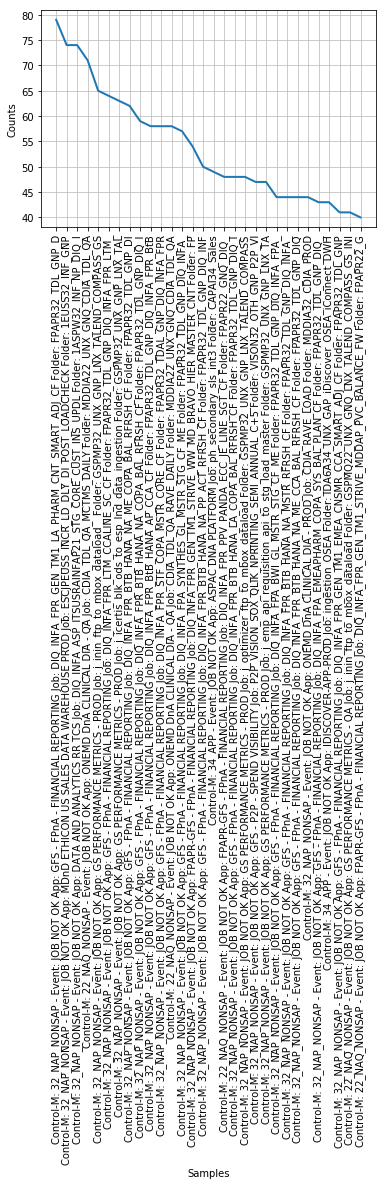

In [78]:
count = nltk.FreqDist(data.Description.values)
count.plot(30)

In [79]:
final_doc = data['Description']
all_documents = tuple(final_doc)

In [80]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(all_documents)
print (tfidf_matrix.shape)
print(tfidf_matrix)

(41363, 44130)
  (0, 38755)	0.5729531961797868
  (0, 15760)	0.2915224041217272
  (0, 33321)	0.2364577074873906
  (0, 43345)	0.11698681716950096
  (0, 32876)	0.23992038386965306
  (0, 43457)	0.1555913056520927
  (0, 25721)	0.6598262764320073
  (1, 43457)	0.18479020734859472
  (1, 23234)	0.24581416091079075
  (1, 19674)	0.15962809362565972
  (1, 3547)	0.30755555498743453
  (1, 19677)	0.17447094094619978
  (1, 2718)	0.47965240103400897
  (1, 22438)	0.2563252939346045
  (1, 39553)	0.19685188455735012
  (1, 22697)	0.1632737447709223
  (1, 22669)	0.2072901670233933
  (1, 8213)	0.5922575833138024
  (2, 23234)	0.08145521671430207
  (2, 19674)	0.10579163471943188
  (2, 3547)	0.2038288135261714
  (2, 19677)	0.11562855656862235
  (2, 23215)	0.10955392566336246
  (2, 40407)	0.12310256450590834
  (2, 42567)	0.11235676924322091
  :	:
  (41361, 16426)	0.2609621220299387
  (41361, 29724)	0.45332850119188833
  (41361, 33126)	0.33033859371080837
  (41361, 38647)	0.38593153693875987
  (41361, 16538)	0.39

In [81]:
reindexed_data= data["Description"]

data_text = data[['Description']]
data_text['index'] = data_text.index
documents=data_text


print(len(documents))
print(documents[:5])

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk


def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

41363
                                         Description  index
0  SIMS  blank page when open with IE\r\n??IE ??S...      0
1  For dim_slt_id=203, dim_task_id=1658 exited wi...      1
2  For DIM_SLT_ID=203, following task(s) violated...      2
4                            > DS huddle Login issue      4
5  This is just a question.\r\nDo Secondary Admin...      5


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [82]:
from nltk.stem.porter import *
stemmer = PorterStemmer()
stemmer.stem('identified')


doc_sample = documents[documents['index'] == 15].values[0][0]
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))


processed_docs = documents['Description'].map(preprocess)
processed_docs[:5]

original document: 
['ds', 'huddle', 'unable', 'to', 'access']


 tokenized and lemmatized document: 
['huddl', 'unabl', 'access']


0                        [sim, blank, page, open, sim]
1    [dim_slt_id, dim_task_id, exit, statu, fail, f...
2    [dim_slt_id, follow, task, violat, task_end_de...
4                                 [huddl, login, issu]
5    [question, secondari, admin, account, admin_ss...
Name: Description, dtype: object

## LDA with Gensim:

### Create a dictionary from the data, then convert to bag-of-words corpus and save the dictionary and corpus for future use.

In [83]:
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 blank
1 open
2 page
3 sim
4 dim_slt_id
5 dim_task_id
6 exit
7 fact_run_id
8 fail
9 statu
10 constraint


In [84]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[123]

[(19, 2),
 (29, 1),
 (30, 1),
 (32, 1),
 (33, 1),
 (41, 1),
 (49, 1),
 (50, 1),
 (51, 2),
 (54, 1),
 (91, 1),
 (235, 1),
 (269, 1),
 (332, 1),
 (333, 1),
 (334, 1),
 (335, 2)]

In [85]:
#Preview Bag Of Words for our sample preprocessed document.
bow_doc_123 = bow_corpus[123]
for i in range(len(bow_doc_123)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_123[i][0], 
                                               dictionary[bow_doc_123[i][0]], 
bow_doc_123[i][1]))

Word 19 ("issu") appears 2 time.
Word 29 ("affect") appears 1 time.
Word 30 ("attempt") appears 1 time.
Word 32 ("begin") appears 1 time.
Word 33 ("busi") appears 1 time.
Word 41 ("impact") appears 1 time.
Word 49 ("step") appears 1 time.
Word 50 ("take") appears 1 time.
Word 51 ("troubleshoot") appears 2 time.
Word 54 ("unabl") appears 1 time.
Word 91 ("view") appears 1 time.
Word 235 ("person") appears 1 time.
Word 269 ("email") appears 1 time.
Word 332 ("combin") appears 1 time.
Word 333 ("membership") appears 1 time.
Word 334 ("point") appears 1 time.
Word 335 ("uniqu") appears 2 time.


In [86]:
#TF-IDF
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.4082882512557055),
 (1, 0.307018582241215),
 (2, 0.30722830637096293),
 (3, 0.8029016513929846)]


### Finding out 5 topics using LDA

In [87]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=5, id2word=dictionary, passes=2, workers=2)

In [88]:
# Print the results
import pickle

# Here we can assign topic names to each topic list, you can specify the number of words you want to have shown (e.g num_words = 5)
result = lda_model.print_topics(num_topics=5, num_words=5)
print(result)

for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

[(0, '0.091*"issu" + 0.077*"troubleshoot" + 0.045*"busi" + 0.040*"impact" + 0.040*"affect"'), (1, '0.138*"folder" + 0.126*"control" + 0.124*"event" + 0.063*"prod" + 0.060*"report"'), (2, '0.036*"jira" + 0.022*"http" + 0.022*"aspac" + 0.019*"report" + 0.019*"product"'), (3, '0.129*"dim_task_id" + 0.119*"task_nam" + 0.103*"start_tim" + 0.103*"end_tim" + 0.071*"dim_slt_id"'), (4, '0.025*"error" + 0.023*"access" + 0.020*"user" + 0.019*"http" + 0.016*"data"')]
Topic: 0 
Words: 0.091*"issu" + 0.077*"troubleshoot" + 0.045*"busi" + 0.040*"impact" + 0.040*"affect" + 0.039*"take" + 0.039*"step" + 0.039*"attempt" + 0.038*"begin" + 0.024*"user"
Topic: 1 
Words: 0.138*"folder" + 0.126*"control" + 0.124*"event" + 0.063*"prod" + 0.060*"report" + 0.033*"financi" + 0.032*"fpapr" + 0.030*"fpna" + 0.020*"data" + 0.018*"perform"
Topic: 2 
Words: 0.036*"jira" + 0.022*"http" + 0.022*"aspac" + 0.019*"report" + 0.019*"product" + 0.018*"platform" + 0.016*"talk" + 0.016*"page" + 0.016*"link" + 0.014*"capai"
Top

In [89]:
# put these in a file and name the topics
with open("lda_topics_result.txt", "w") as f:
    for s in result:
        f.write(str(s) +"\n")

### pyLDAvis help to interpret the topics in a topic model that has been fit to a corpus of text data

In [90]:
# Visualize
import pyLDAvis.gensim

lda_display = pyLDAvis.gensim.prepare(lda_model, bow_corpus,dictionary, sort_topics=True)
pyLDAvis.display(lda_display)

In [91]:
from collections import OrderedDict

data_lda = {i: OrderedDict(lda_model.show_topic(i,25)) for i in range(5)}

In [92]:
import pandas as pd

df_lda = pd.DataFrame(data_lda)
print(df_lda.shape)
df_lda = df_lda.fillna(0).T
print(df_lda.shape)

(101, 5)
(5, 101)


In [93]:
df_lda

,access,affect,amet,analyt,aspac,aspw,attach,attempt,begin,brows,...,team,ticket,time,tri,troubleshoot,unabl,user,violat,work,yxmd
0,0.008780,0.039718,0.000000,0.000000,0.000000,0.000000,0.000000,0.038891,0.038455,0.000000,...,0.004798,0.000000,0.003945,0.000000,0.076794,0.004456,0.024346,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.009389,0.013554,0.000000,0.006445,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.021938,0.000000,0.000000,0.000000,0.000000,0.013785,...,0.000000,0.010497,0.000000,0.000000,0.000000,0.000000,0.010601,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.061781,0.000000,0.003369
4,0.022731,0.000000,0.000000,0.000000,0.000000,0.000000,0.008104,0.000000,0.000000,0.000000,...,0.008018,0.000000,0.000000,0.007781,0.000000,0.013544,0.020402,0.000000,0.006685,0.000000


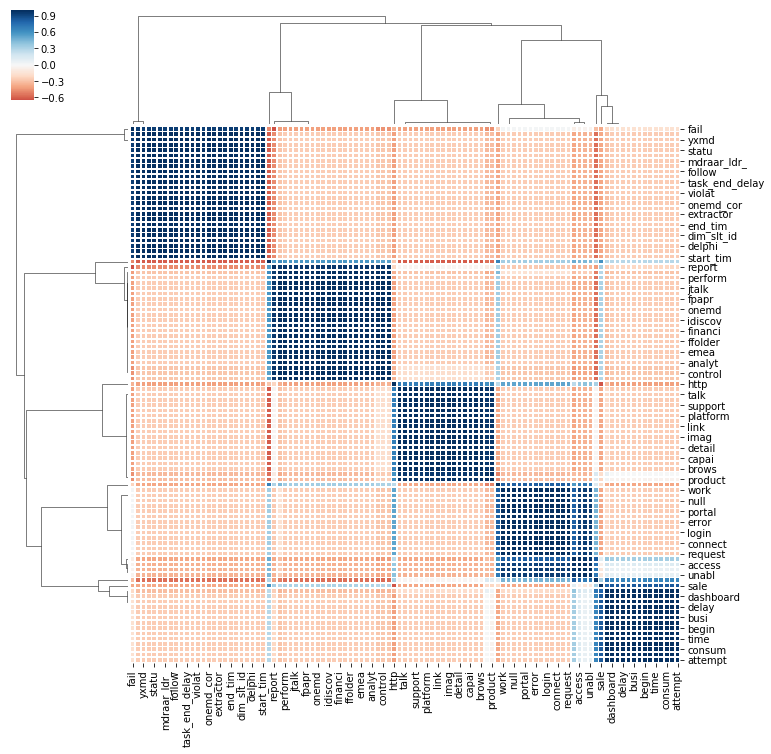

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

g=sns.clustermap(df_lda.corr(), center=0, cmap="RdBu", metric='cosine', linewidths=.75, figsize=(12, 12))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

In [95]:
MAX_LENGTH = 500
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data.Description.values)
post_seq = tokenizer.texts_to_sequences(data.Description.values)
post_seq_padded = pad_sequences(post_seq, maxlen=MAX_LENGTH)

In [96]:
def data_set_split (y):
    X_train, X_test, y_train, y_test = train_test_split(post_seq_padded, y, test_size=0.3,random_state=42)
    return X_train, X_test, y_train, y_test

In [97]:

vocab_size = len(tokenizer.word_index) + 1

## Deep Learning Model Simple

In [98]:
from sklearn.externals import joblib

In [99]:
def model_training(num_class, model_file):    
    inputs = Input(shape=(MAX_LENGTH, ))
    embedding_layer = Embedding(vocab_size,
                            128,
                            input_length=MAX_LENGTH)(inputs)
    x = Flatten()(embedding_layer)
    x = Dense(32, activation='relu')(x)
    predictions = Dense(num_class, activation='softmax')(x)
    model = Model(inputs=[inputs], outputs=predictions)
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])
    model.summary()
    checkpointer = ModelCheckpoint(model_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    history = model.fit([X_train], batch_size=124, y=to_categorical(y_train), verbose=1, validation_split=0.25, 
          shuffle=True, epochs=15, callbacks=[checkpointer])
    
    df = pd.DataFrame({'epochs':history.epoch, 'accuracy': history.history['acc'], 'validation_accuracy': history.history['val_acc']})
    g = sns.pointplot(x="epochs", y="accuracy", data=df, fit_reg=False)
    g = sns.pointplot(x="epochs", y="validation_accuracy", data=df, fit_reg=False, color='green')
    
    return model

### Training Model to predict Support Group who might be able to resolved the ticket

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 500)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 500, 128)          5552128   
_________________________________________________________________
flatten_1 (Flatten)          (None, 64000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2048032   
_________________________________________________________________
dense_2 (Dense)              (None, 17)                561       
Total params: 7,600,721
Trainable params: 7,600,721
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 217

['model-simple_grp.pkl']

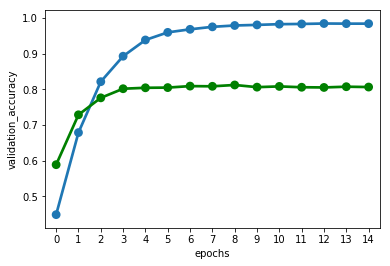

In [100]:
X_train, X_test, y_train, y_test = data_set_split(y_grp)

model_file = 'weights-simple_grp.hdf5'
model = model_training(num_class_grp, model_file)
joblib.dump(model,'model-simple_grp.pkl')

### Training Model to preduct Priority of the ticket

In [101]:
predicted = model.predict(X_test)
predicted = np.argmax(predicted, axis=1)
accuracy_score(y_test, predicted)

0.8095736965105972

In [102]:
# This utility function is from the sklearn docs: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)

In [103]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import itertools

In [104]:
# Use sklearn utility to convert label strings to numbered index
encoder = LabelEncoder()
#This should be adjusted to the Predictor
#encoder.fit(data.Resolution_category.values)
encoder.fit(data.Resolved_by_group.values)
text_labels = encoder.classes_ 


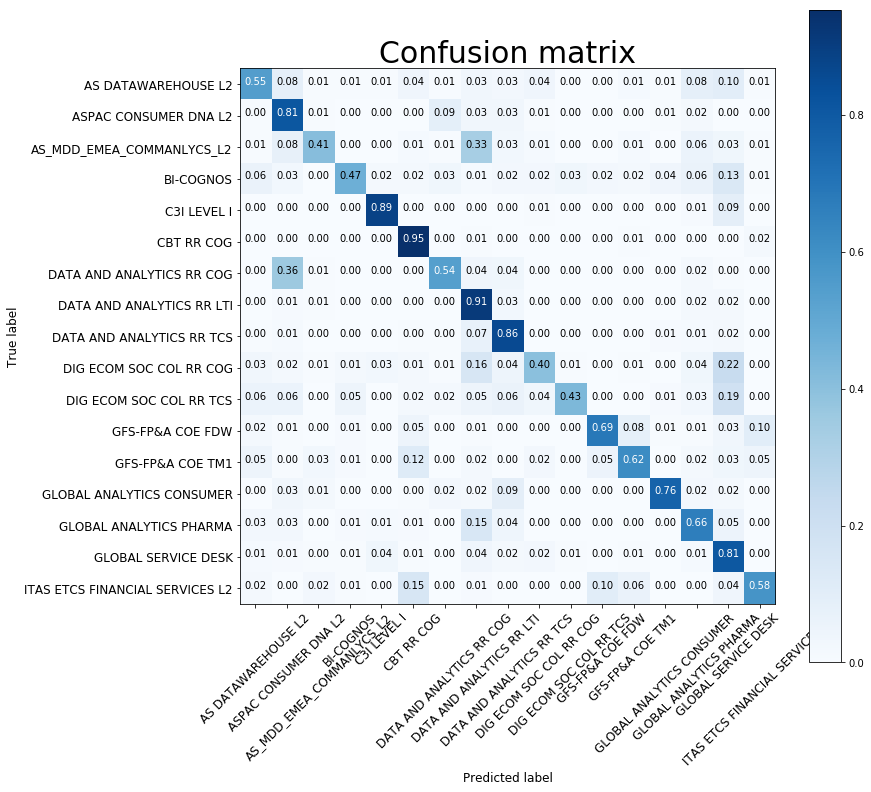

In [105]:
cnf_matrix = confusion_matrix(y_test, predicted)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
plt.show()

## RNN with LSTM Layer

In [139]:
def lstm_model_training(num_class, model_file): 
    inputs = Input(shape=(MAX_LENGTH, ))
    embedding_layer = Embedding(vocab_size,
                                128,
                                input_length=MAX_LENGTH)(inputs)
    x = LSTM(64)(embedding_layer)
    x = Dense(32, activation='relu')(x)
    predictions = Dense(num_class, activation='softmax')(x)
    model_lstm = Model(inputs=[inputs], outputs=predictions)
    model_lstm.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['acc'])
    model_lstm.summary()

    checkpointer = ModelCheckpoint(model_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    history = model_lstm.fit([X_train], batch_size=64, y=to_categorical(y_train), verbose=1, validation_split=0.25, 
                             shuffle=True, epochs=10, callbacks=[checkpointer])
    
    df = pd.DataFrame({'epochs':history.epoch, 'accuracy': history.history['acc'], 'validation_accuracy': history.history['val_acc']})
    g = sns.pointplot(x="epochs", y="accuracy", data=df, fit_reg=False)
    g = sns.pointplot(x="epochs", y="validation_accuracy", data=df, fit_reg=False, color='green')
    return model_lstm


### Training Predictor for Support Group using LSTM RNN 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 500)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 500, 128)          1524480   
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 10)                330       
Total params: 1,576,298
Trainable params: 1,576,298
Non-trainable params: 0
_________________________________________________________________
Train on 10986 samples, validate on 3663 samples
Epoch 1/20
10986/10986 [==============================] - 96s 9ms/step - loss: 1.46

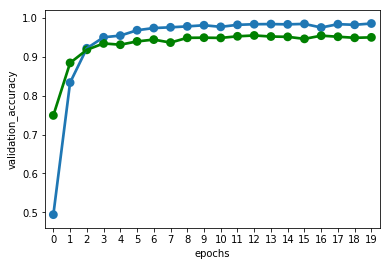

In [140]:
X_train, X_test, y_train, y_test = data_set_split(y_grp)
model_lstm = lstm_model_training(num_class_grp,"weights_grp.hdf5")
joblib.dump(model_lstm,'model_grp.pkl')
predicted = model_lstm.predict(X_test)


In [ ]:
predicted
predicted = np.argmax(predicted, axis=1)
accuracy_score(y_test, predicted)

0.9546632124352331

In [ ]:
cnf_matrix = confusion_matrix(y_test, predicted)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted))